In [93]:
import open3d as o3d
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import Delaunay
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt


In [94]:
# Function to create transects by selecting points around target theta2 values
def create_transects_around_target_theta2(point_cloud, target_theta2_values, theta_range=1.5):
    return [point_cloud[(point_cloud['theta'] >= target_theta2 - theta_range) & 
                        (point_cloud['theta'] <= target_theta2 + theta_range)] 
            for target_theta2 in target_theta2_values]

# Function to check if all values in the point_cloud_df have been assigned to a transect
def check_unassigned_points(point_cloud_df, transects):
    assigned_points = pd.concat(transects)
    return point_cloud_df[~point_cloud_df.index.isin(assigned_points.index)].shape[0]

In [95]:
def singe_file(pcd_file_path):
    pcd = o3d.io.read_point_cloud(pcd_file_path)
    # create function that does all the above steps
    # Extract points as a NumPy array
    xyz = np.asarray(pcd.points)

    # Convert to spherical coordinates with the z-axis as the reference axis
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]
    rho = np.sqrt(x**2 + y**2 + z**2)
    phi = np.arctan2(y, x)
    theta_degrees = np.degrees(np.arccos(z / rho))

    # Create a DataFrame to store the point cloud data along with theta values
    point_cloud_df = pd.DataFrame({'x': x, 'y': y, 'z': z, 'theta': theta_degrees})

    # Define the target theta2 values for each transect
    target_theta2_values = [97.2, 92.5, 90.0, 87.6, 84.9, 82.7, 80.4, 77.9, 75.7, 73.0, 70.9, 68.0, 66.0, 63.4, 60.9, 55.7]

    # Generate transects with theta2 values around the specified target values with increased range
    transects = create_transects_around_target_theta2(point_cloud_df, target_theta2_values, theta_range=1)

    # Rename the transects starting from 1 going to 16
    transect_names = [f'Transect {i}' for i in range(1, 17)]
    transect_dict = dict(zip(transect_names, transects))

    # Check for unassigned points
    unassigned_points_count = check_unassigned_points(point_cloud_df, transects)
    if unassigned_points_count > 0:
        print(f"Unassigned points count: {unassigned_points_count}")

    # Remove the 'theta' column from each transect DataFrame
    for name in transect_dict:
        transect_dict[name] = transect_dict[name].drop(columns=['theta'])

    # Select Transect 3 for transformation
    A = 3
    transect_A = transect_dict[f'Transect {A}']

    # Convert transect DataFrame to NumPy array
    transect_xyz = transect_A[['x', 'y', 'z']].values

    # Apply the transformation matrix
    transect_xyz_homogeneous = np.hstack((transect_xyz, np.ones((transect_xyz.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(transformation_matrix.T)[:, :3]

    # Create a DataFrame for the transformed transect
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

    # Compute the translation back offsets for X and Y only
    translation_back = np.eye(4)
    translation_back[0, 3] = -transformation_matrix[0, 3]
    translation_back[1, 3] = -transformation_matrix[1, 3]

    # Apply the translation back to the origin for X and Y
    transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(translation_back.T)[:, :3]
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

    # Coordinates of the two points in the RD-coordinate system
    point1 = np.array([72462.703, 452067.267, 4.101, 1])  # point3
    point2 = np.array([72448.355, 452047.630, 4.075, 1])  # point4

    # Compute the direction vector
    direction = point1 - point2

    # Project the direction vector onto the XY-plane
    direction_xy = direction[:2]  # Only consider the X and Y components

    # Compute the angle to the Y-axis
    angle = np.arctan2(direction_xy[0], direction_xy[1])  # atan2(X, Y)

    # Construct the rotation matrix for rotation around the Z-axis
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0, 0],
        [np.sin(angle),  np.cos(angle), 0, 0],
        [0,              0,             1, 0],
        [0,              0,             0, 1]
    ])

    # Apply the rotation and translation matrix to the two points
    new_point1 = np.dot(translation_back, point1)
    new_point2 = np.dot(translation_back, point2)
    new_point1 = np.dot(rotation_matrix, new_point1)
    new_point2 = np.dot(rotation_matrix, new_point2)

    # Compute the new baseline axis
    baseline_axis = np.mean([new_point1[0], new_point2[0]])

    # Apply the rotation matrix to the point cloud
    transect_xyz_homogeneous = np.hstack((transect_transformed_df[['x', 'y', 'z']].values, np.ones((transect_transformed_df.shape[0], 1))))
    transect_xyz_transformed = transect_xyz_homogeneous.dot(rotation_matrix.T)[:, :3]
    transect_transformed_df = pd.DataFrame(transect_xyz_transformed, columns=['x', 'y', 'z'])

     # remove points between z= [z1,z2], x=[x1,x2]
    transect_transformed_df = transect_transformed_df[(transect_transformed_df['z'] < z1) | (transect_transformed_df['z'] > z2) | (transect_transformed_df['x'] < x1) | (transect_transformed_df['x'] > x2)]
    # remove points above z=6
    transect_transformed_df = transect_transformed_df[transect_transformed_df['z'] < 6]
    
    # Translate the point cloud to align with the baseline axis
    transect_transformed_df['x'] = transect_transformed_df['x'] - baseline_axis + 100
    # remove everything above x = 105
    transect_transformed_df = transect_transformed_df[transect_transformed_df['x'] < 105]
    
    return transect_transformed_df




In [96]:
# Define the transformation matrix gathered from CloudCompare georeferencing
transformation_matrix = np.array([
    [-0.000024980998,  0.000812676153, -0.000583815563,  492.143829345703],
    [ 0.000007067249, -0.000583839603, -0.000813012011,  127.397300720215],
    [-0.001000616350, -0.000024412553,  0.000008833092,    4.558271408081],
    [ 0.000000000000,  0.000000000000,  0.000000000000,    1.000000000000]
])

transformation_matrix[0,3]+=  72000.00 
transformation_matrix[1,3]+=  452000.00
transformation_matrix[3,3]=1

# to be removed area
z1 ,z2,x1,x2= 1.6 , 5.5, -0.9, 0.2 

In [97]:
import datetime

def extract_timestamp(filename):
    """
    Extracts the timestamp from the given filename.

    Parameters:
    filename (str): The filename from which to extract the timestamp.

    Returns:
    datetime: The extracted timestamp as a datetime object.
    """
    try:
        # Extract the date part from the filename
        date_part = filename.split('__')[1].split('_')[1:4]
        day = date_part[0][2:]
        date_corrected = [day] + date_part[1:]
        date_str = '_'.join(date_corrected)

        # Extract the time part from the filename
        time_part = filename.split('__')[2].replace('.PCD', '')

        # Construct the full date-time string
        datetime_str = f"{date_str} {time_part}"

        # Parse the date-time string into a datetime object
        timestamp = datetime.datetime.strptime(datetime_str, "%d_%m_%Y %H_%M_%S.%f")
        return timestamp
    except Exception as e:
        print(f"Error extracting timestamp: {e}")
        return None

# Example usage
filename = "Lidar1__Pcl_0021_12_2024__12_27_18.780.PCD"
timestamp = extract_timestamp(filename)
timestamp

datetime.datetime(2024, 12, 21, 12, 27, 18, 780000)

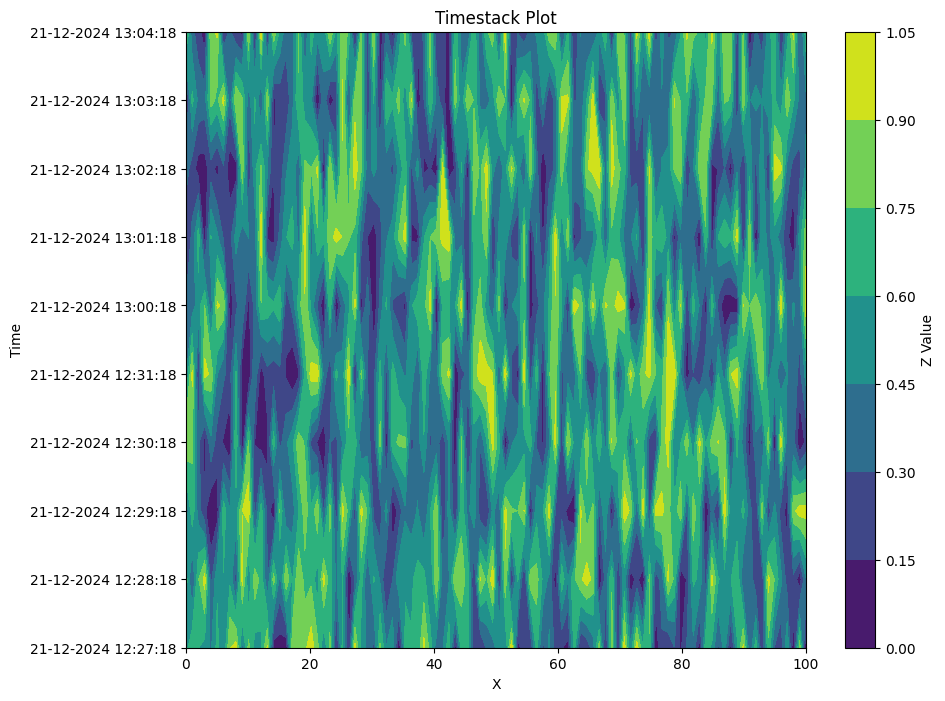

In [98]:
# Generate synthetic data for 10 files
filenames = [
    "Lidar1__Pcl_0021_12_2024__12_27_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__12_28_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__12_29_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__12_30_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__12_31_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__13_00_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__13_01_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__13_02_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__13_03_18.780.PCD",
    "Lidar1__Pcl_0021_12_2024__13_04_18.780.PCD"
]

# Extract timestamps using the function
timestamps = [extract_timestamp(filename) for filename in filenames]

# Generate synthetic x, y, z data
np.random.seed(0)
x_data = np.linspace(0, 100, 100)
y_data = np.array([i for i in range(10)])  # 10 different time points
z_data = np.random.rand(10, 100)  # 10 time points, 100 x points

# Create the timestack plot
plt.figure(figsize=(10, 8))
plt.contourf(x_data, y_data, z_data, cmap='viridis')
plt.colorbar(label='Z Value')
plt.xlabel('X')
plt.ylabel('Time')
plt.yticks(ticks=y_data, labels=[ts.strftime("%d-%m-%Y %H:%M:%S") for ts in timestamps if ts])  # Include date and exclude milliseconds
plt.title('Timestack Plot')
plt.show()

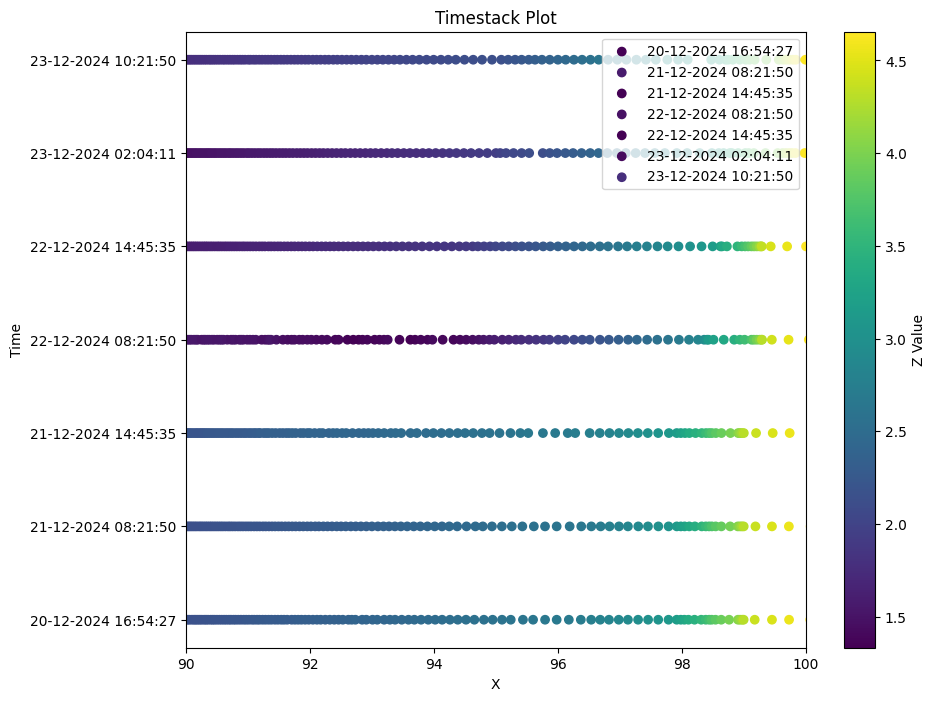

In [99]:
# Point cloud files
pcd_files = [
    r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0020_12_2024__16_54_27.780.PCD",
    r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0021_12_2024__08_21_50.530.PCD",
    r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0021_12_2024__14_45_35.530.PCD",
    r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0022_12_2024__08_21_50.530.PCD",
    r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0022_12_2024__14_45_35.530.PCD",
    r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0023_12_2024__02_04_11.030.PCD",
    r"D:\HybridDune\20241223_LiDAR1\Lidar1__Pcl_0023_12_2024__10_21_50.530.PCD"
]

# Process each point cloud through the singe_file function and extract timestamps
dataframes = [singe_file(pcd_file) for pcd_file in pcd_files]
timestamps = [extract_timestamp(pcd_file) for pcd_file in pcd_files]

# Generate synthetic y_data based on the number of files
y_data = np.array([i for i in range(len(pcd_files))])

# Create the timestack plot
plt.figure(figsize=(10, 8))
for i, df in enumerate(dataframes):
    plt.scatter(df['x'], np.full_like(df['x'], y_data[i]), c=df['z'], cmap='viridis', label=timestamps[i].strftime("%d-%m-%Y %H:%M:%S"))

plt.colorbar(label='Z Value')
plt.xlabel('X')
plt.ylabel('Time')
plt.yticks(ticks=y_data, labels=[ts.strftime("%d-%m-%Y %H:%M:%S") for ts in timestamps])
plt.title('Timestack Plot')
plt.xlim(90,100)
plt.legend(loc='upper right')
plt.show()

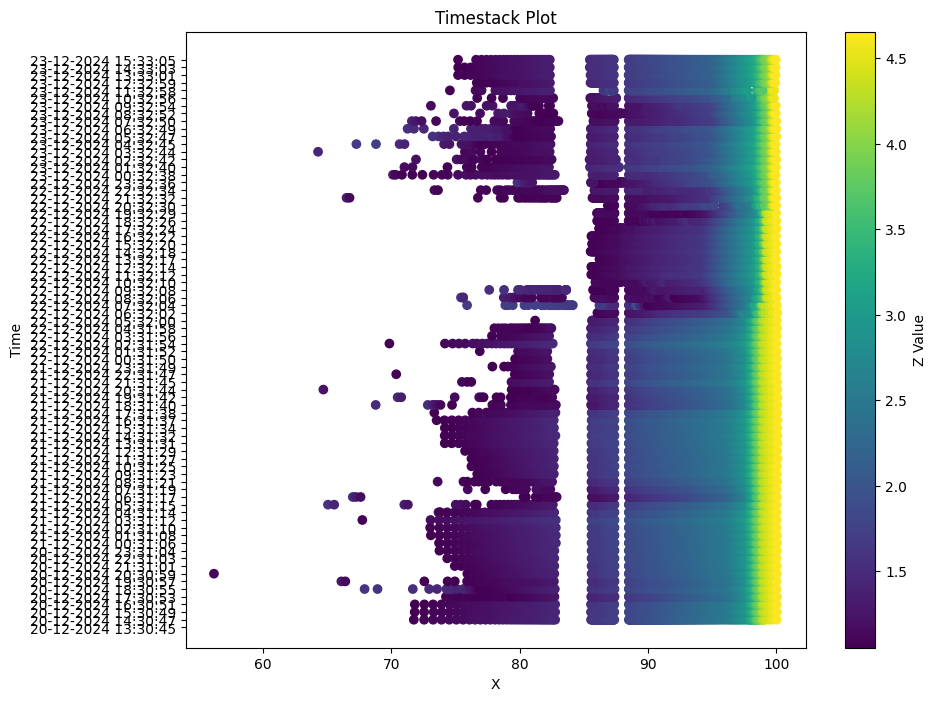

In [100]:
# Directory containing the point cloud files
directory = r"D:\HybridDune\20241223_LiDAR1"

# List all files in the directory
all_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.PCD')])

# Skip the first 1000 files and select every 14400th file
selected_files = all_files[1000::14400]

# Process each selected point cloud file and extract timestamps
dataframes = [singe_file(pcd_file) for pcd_file in selected_files]
timestamps = [extract_timestamp(pcd_file) for pcd_file in selected_files]

# Generate synthetic y_data based on the number of selected files
y_data = np.array([i for i in range(len(selected_files))])

# Create the timestack plot
plt.figure(figsize=(10, 8))
for i, df in enumerate(dataframes):
    plt.scatter(df['x'], np.full_like(df['x'], y_data[i]), c=df['z'], cmap='viridis', label=timestamps[i].strftime("%d-%m-%Y %H:%M:%S"))

plt.colorbar(label='Z Value')
plt.xlabel('X')
plt.ylabel('Time')
plt.yticks(ticks=y_data, labels=[ts.strftime("%d-%m-%Y %H:%M:%S") for ts in timestamps])
plt.title('Timestack Plot')
# plt.legend(loc='upper right')
plt.show()

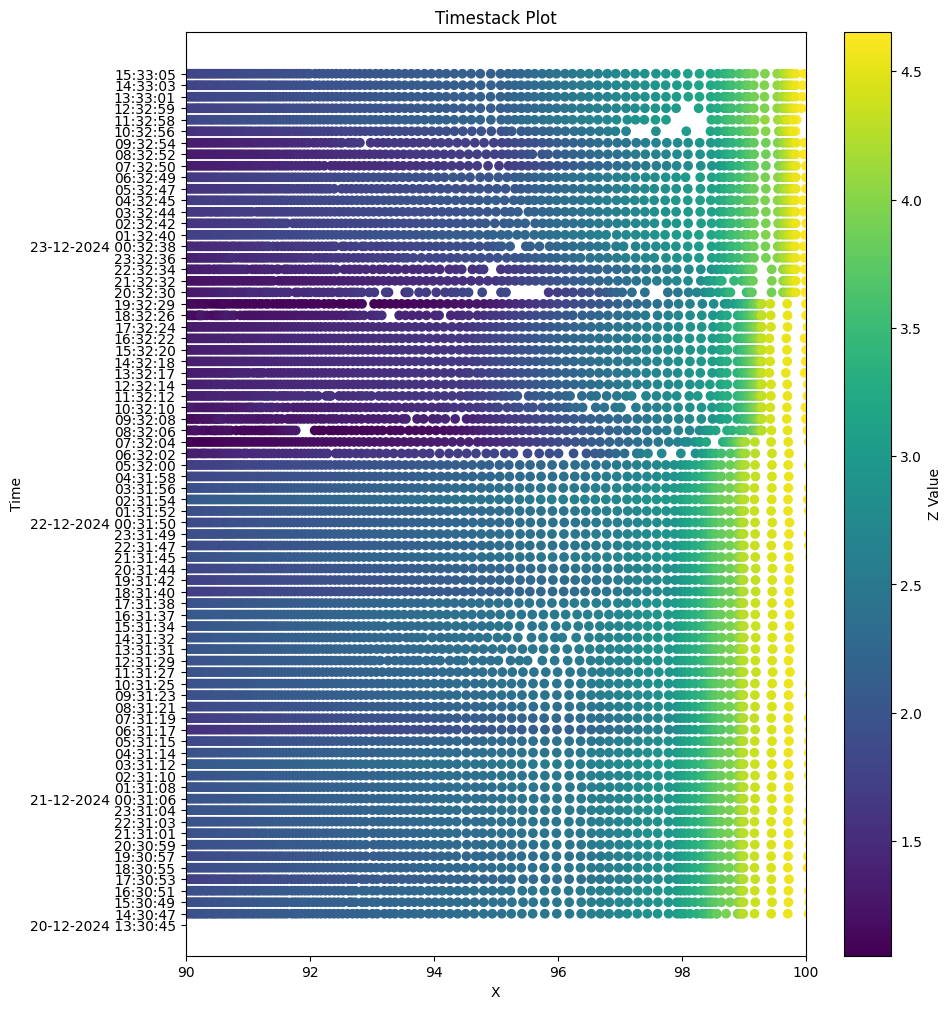

In [101]:
# Directory containing the point cloud files
directory = r"D:\HybridDune\20241223_LiDAR1"

# List all files in the directory
all_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.PCD')])

# Skip the first 1000 files and select every 14400th file
selected_files = all_files[1000::14400]

# Process each selected point cloud file and extract timestamps
dataframes = [singe_file(pcd_file) for pcd_file in selected_files]
timestamps = [extract_timestamp(pcd_file) for pcd_file in selected_files]

# Generate synthetic y_data based on the number of selected files
y_data = np.array([i for i in range(len(selected_files))])

# Create the timestack plot
plt.figure(figsize=(10, 12))
for i, df in enumerate(dataframes):
    plt.scatter(df['x'], np.full_like(df['x'], y_data[i]), c=df['z'], cmap='viridis')

plt.colorbar(label='Z Value')
plt.xlabel('X')
plt.ylabel('Time')
plt.xlim(90, 100)

# Generate y-axis labels
y_labels = []
prev_date = None
for ts in timestamps:
    date_label = ts.strftime("%d-%m-%Y")
    time_label = ts.strftime("%H:%M:%S")
    if prev_date != date_label:
        y_labels.append(f"{date_label} {time_label}")
        prev_date = date_label
    else:
        y_labels.append(time_label)

plt.yticks(ticks=y_data, labels=y_labels)
plt.title('Timestack Plot')
plt.show()

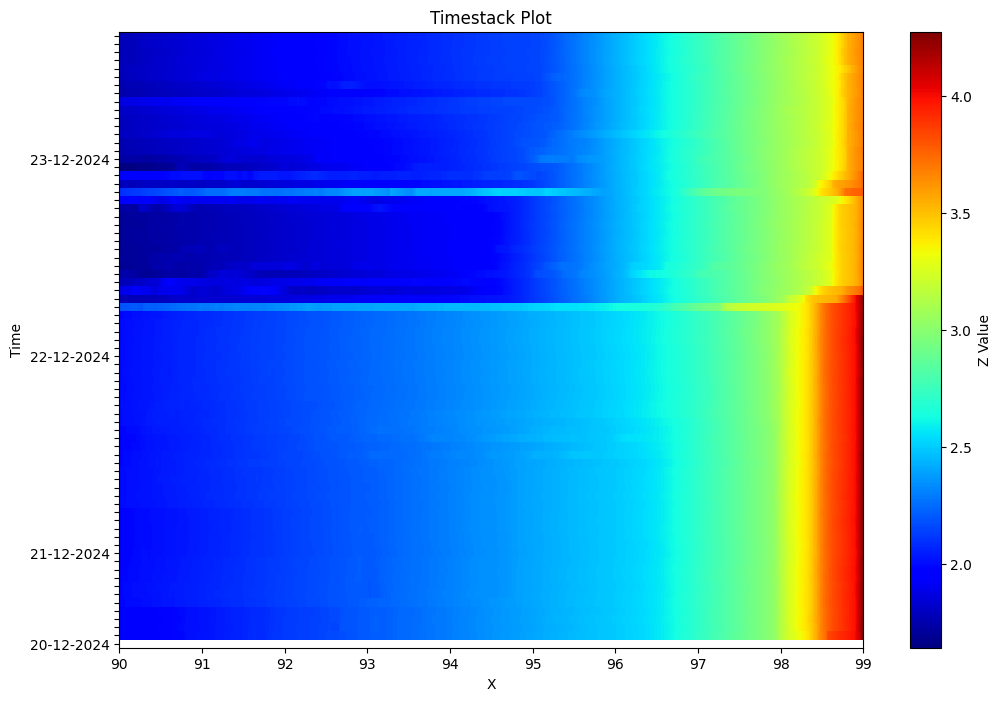

In [108]:
# Directory containing the point cloud files
directory = r"D:\HybridDune\20241223_LiDAR1"

# List all files in the directory
all_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.PCD')])

# Skip the first 1000 files and select every 14400th file
selected_files = all_files[1000::14400]

# Process each selected point cloud file and extract timestamps
dataframes = [singe_file(pcd_file) for pcd_file in selected_files]
timestamps = [extract_timestamp(pcd_file) for pcd_file in selected_files]

# Generate synthetic y_data based on the number of selected files
y_data = np.array([i for i in range(len(selected_files))])

# Create a meshgrid for x, y, z values
x_values = np.linspace(90, 99, 1000)  # Increased resolution
y_values = y_data
z_values = np.full((len(y_values), len(x_values)), np.nan)  # Initialize with NaNs

for i, df in enumerate(dataframes):
    if not df.empty and 'x' in df.columns and 'z' in df.columns:
        z_interp = np.interp(x_values, df['x'], df['z'])
        z_values[i, :] = z_interp

# Create the timestack plot using pcolormesh with the jet colormap
plt.figure(figsize=(12, 8))
plt.pcolormesh(x_values, y_values, z_values, cmap='jet', shading='auto')
plt.colorbar(label='Z Value')
plt.xlabel('X')
plt.ylabel('Time')
plt.xlim(90, 99)

# Generate y-axis labels
y_labels = []
prev_date = None
for ts in timestamps:
    date_label = ts.strftime("%d-%m-%Y")
    if prev_date != date_label:
        y_labels.append(date_label)
        prev_date = date_label
    else:
        y_labels.append('')

plt.yticks(ticks=y_data, labels=y_labels)
plt.title('Timestack Plot')
plt.show()

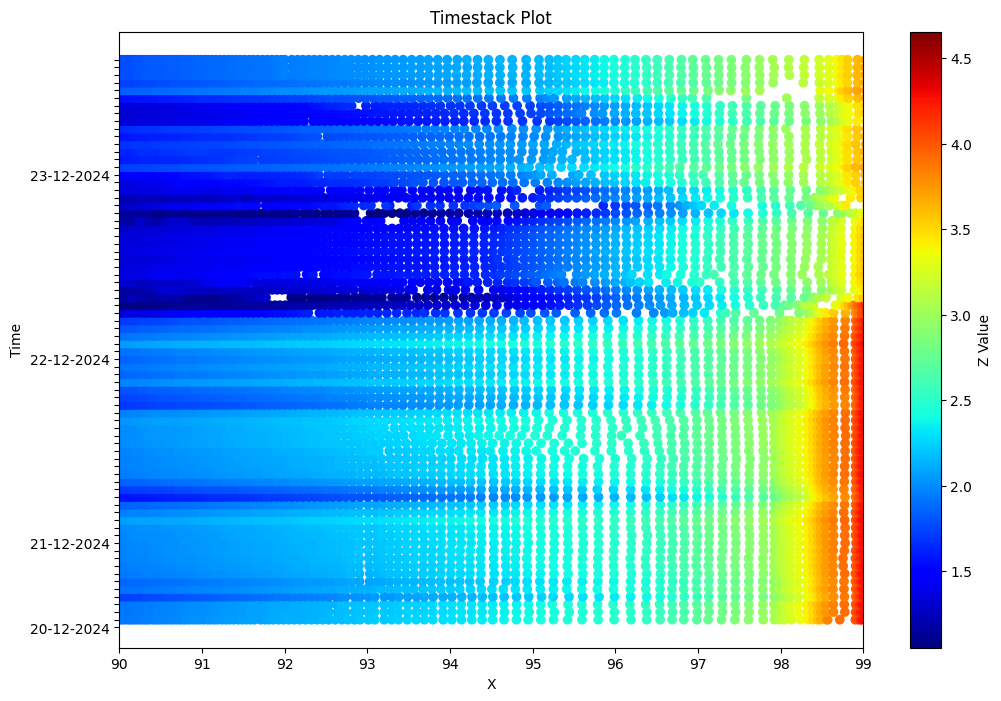

In [109]:
# Directory containing the point cloud files
directory = r"D:\HybridDune\20241223_LiDAR1"

# List all files in the directory
all_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.PCD')])

# Skip the first 1000 files and select every 14400th file
selected_files = all_files[1000::14400]

# Process each selected point cloud file and extract timestamps
dataframes = [singe_file(pcd_file) for pcd_file in selected_files]
timestamps = [extract_timestamp(pcd_file) for pcd_file in selected_files]

# Generate synthetic y_data based on the number of selected files
y_data = np.array([i for i in range(len(selected_files))])

# Create the scatter plot
plt.figure(figsize=(12, 8))
for i, df in enumerate(dataframes):
    if not df.empty and 'x' in df.columns and 'z' in df.columns:
        plt.scatter(df['x'], np.full_like(df['x'], y_data[i]), c=df['z'], cmap='jet', label=f"File {i}")

plt.colorbar(label='Z Value')
plt.xlabel('X')
plt.ylabel('Time')
plt.xlim(90, 99)

# Generate y-axis labels
y_labels = []
prev_date = None
for ts in timestamps:
    date_label = ts.strftime("%d-%m-%Y")
    if prev_date != date_label:
        y_labels.append(date_label)
        prev_date = date_label
    else:
        y_labels.append('')

plt.yticks(ticks=y_data, labels=y_labels)
plt.title('Timestack Plot')
plt.show()

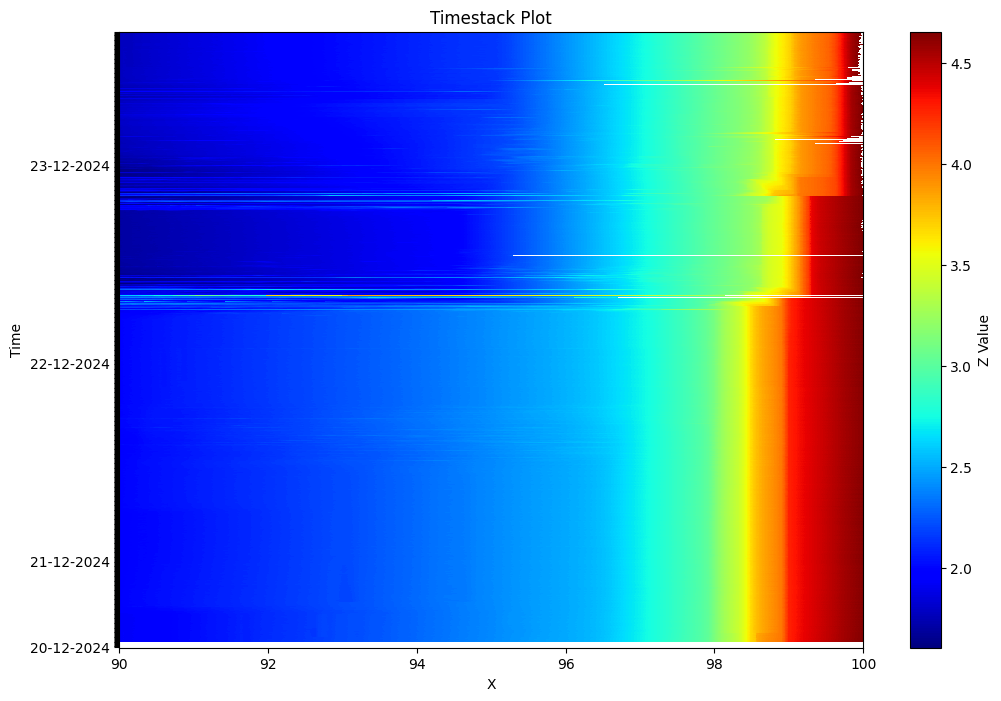

In [113]:
# Directory containing the point cloud files
directory = r"D:\HybridDune\20241223_LiDAR1"

# List all files in the directory
all_files = sorted([os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.PCD')])

# Skip the first 1000 files and select every 14400th file
selected_files = all_files[1000::1440]

# Process each selected point cloud file and extract timestamps
dataframes = [singe_file(pcd_file) for pcd_file in selected_files]
timestamps = [extract_timestamp(pcd_file) for pcd_file in selected_files]

# Generate synthetic y_data based on the number of selected files
y_data = np.array([i for i in range(len(selected_files))])

# Create a meshgrid for x, y, z values
x_values = np.linspace(90, 100, 1000)  # Increased resolution
y_values = y_data
z_values = np.full((len(y_values), len(x_values)), np.nan)  # Initialize with NaNs

for i, df in enumerate(dataframes):
    if not df.empty and 'x' in df.columns and 'z' in df.columns:
        # Interpolate only within the range of df['x']
        z_interp = np.interp(x_values, df['x'], df['z'], left=np.nan, right=np.nan)
        z_values[i, :] = z_interp

# Create the timestack plot using pcolormesh with the jet colormap
plt.figure(figsize=(12, 8))
plt.pcolormesh(x_values, y_values, z_values, cmap='jet', shading='auto')
plt.colorbar(label='Z Value')
plt.xlabel('X')
plt.ylabel('Time')
plt.xlim(90, 100)

# Generate y-axis labels
y_labels = []
prev_date = None
for ts in timestamps:
    date_label = ts.strftime("%d-%m-%Y")
    if prev_date != date_label:
        y_labels.append(date_label)
        prev_date = date_label
    else:
        y_labels.append('')

plt.yticks(ticks=y_data, labels=y_labels)
plt.title('Timestack Plot')
plt.show()